# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Adjusting component signs
#### Instructor: sincxpress.com

In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
from pytopo import topoplotIndie

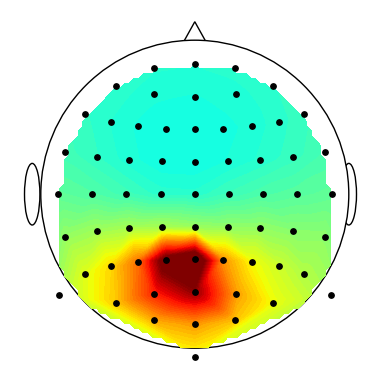

In [ ]:
## simulate data

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files/emptyEEG')
EEG = matfile['EEG'][0,0]
lf  = matfile['lf'][0,0]

# adjust some parameters
EEG['srate']  = 500
EEG['trials'] = 1
EEG['pnts']   = 1000
EEG['times']  = np.arange(EEG['pnts']) / EEG['srate']
EEG['data']   = np.zeros( (EEG['nbchan'][0][0],EEG['pnts'],EEG['trials']) )

# index of dipole to simulate activity in
diploc = 108

# show dipole projection map
topoplotIndie(-lf['Gain'][:,0,diploc],EEG['chanlocs'])


(64, 3, 2004)
(2004, 1000) (64, 2004)


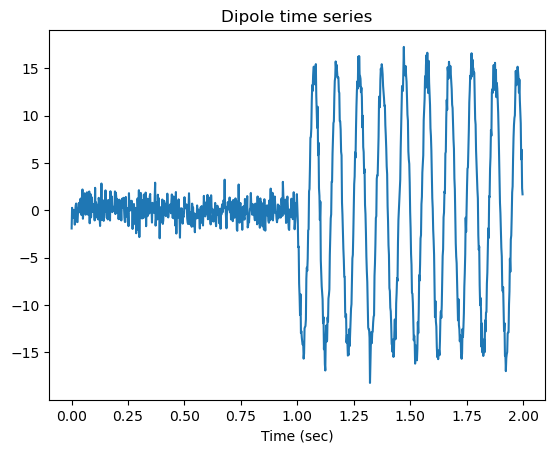

In [ ]:
## create data

lfshape = np.shape(lf['Gain'])
print(lfshape)

# Random data in all brain dipoles
dipole_data = np.random.randn(lfshape[2],EEG['pnts'])

# add signal to second half of dataset
dipole_data[diploc,500:] = -15*np.sin(2*np.pi*10*np.arange(500)/EEG['srate'])
dipole_data[diploc,500:] = -15*np.sin(2*np.pi*10*np.arange(500)/EEG['srate'])+np.random.randn(500)


print(dipole_data.shape,lf['Gain'][:,0,:].shape)
# project data from all dipoles to scalp electrodes
EEG['data'] = lf['Gain'][:,0,:] @ dipole_data

# show dipole time series
plt.plot(EEG['times'],dipole_data[diploc,:])
plt.xlabel('Time (sec)')
plt.title('Dipole time series')
plt.show()

In [25]:
## compute GED

# covariance matrices
covR = np.cov(EEG['data'][:,:500])
covS = np.cov(EEG['data'][:,500:])

# GED
evals,evecs = scipy.linalg.eigh( covS,covR )

#evecs /= np.sqrt(np.sum(evecs**2,axis=0))   # if you were to normalize for ploting multipule vecs

# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]


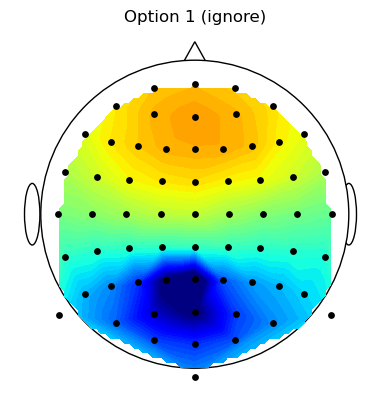

In [26]:
## option 1: ignore the sign

# compute filter forward model and component time series
cmap  = evecs[:,0].T @ covS
cdat1 = evecs[:,0].T @ EEG['data']

# visualize the map
topoplotIndie(cmap,EEG['chanlocs'],'Option 1 (ignore)')


(64,) (64, 64)


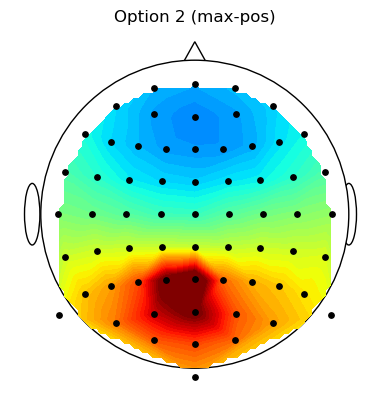

In [32]:
## option 2: force positive max. value

# find max magnitude and its sign
idx = np.argmax(np.abs(cmap))
signOfMax = np.sign(cmap[idx])

# sign-flip the eigenvector
w = evecs[:,0] * signOfMax
print(w.shape,covS.shape)
# re-compute map and component time series
cmap  = w.T @ covS
cdat2 = w.T @ EEG['data']

# visualize the map
topoplotIndie(cmap,EEG['chanlocs'],'Option 2 (max-pos)')


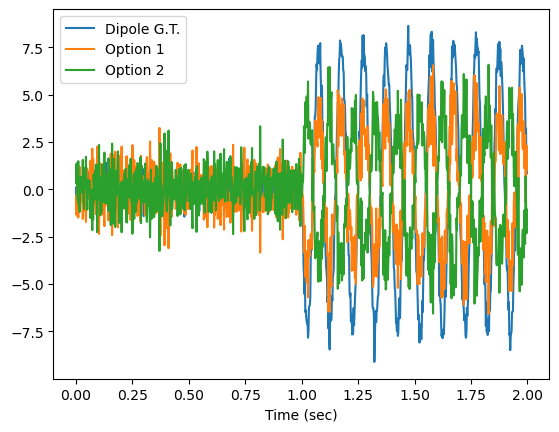

In [28]:
## show all of the component time series

plt.plot(EEG['times'],dipole_data[diploc,:]/2,label='Dipole G.T.')
plt.plot(EEG['times'],cdat1,label='Option 1')
plt.plot(EEG['times'],cdat2,label='Option 2')
plt.xlabel('Time (sec)')
plt.legend()
plt.show()

In [29]:
## option 2b: force sign of a particular electrode

chan2bPos = 'Fz'

for i,c in enumerate(EEG['chanlocs'][0]):
    if chan2bPos==c[0][0]:
        chanidx = i

# find max magnitude and its sign
cmap = evecs[:,0].T @ covS
targetSign = np.sign(cmap[chanidx])

# sign-flip the eigenvector
w = evecs[:,0] * targetSign

# recompute the map and component time series
cmap  = w.T @ covS
cdat2 = w.T @ EEG['data']